QUESTION 1 : Discuss for your project data with spatial and angular similarity algorithms

In [2]:

from astroquery.gaia import Gaia
from astropy.coordinates import SkyCoord
import astropy.units as u
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
# Abell 2218
ra = 16 + (35 / 60) + (51.89 / 3600)
dec = 66 + (12 / 60) + (38.71 / 3600)
radius = 1 * u.deg

coord = SkyCoord(ra=ra, dec=dec, unit=(u.deg, u.deg), frame='icrs')


# In here I choose the rows I want to examine in df from the Gaia dataset(SQL query)
Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source"
job = Gaia.launch_job_async(f"""
    SELECT source_id, ra, dec, parallax, pmra, pmdec, phot_g_mean_mag
    FROM gaiadr3.gaia_source
    WHERE CONTAINS(
        POINT('ICRS', ra, dec),
        CIRCLE('ICRS', {coord.ra.deg}, {coord.dec.deg}, {radius.to(u.deg).value})
    ) = 1
""")


query_sql = job.get_results()
df = query_sql.to_pandas()


INFO: Query finished. [astroquery.utils.tap.core]


In [7]:
center_coord = SkyCoord(ra=coord.ra, dec=coord.dec, unit='deg')

df['distance_arcsec'] = df.apply(
    lambda row: center_coord.separation(
        SkyCoord(ra=row['ra']*u.deg, dec=row['dec']*u.deg)
    ).arcsec,
    axis=1
)

threshold_arcsec = 3600  # 1 derece
spatial_neighbors = df[df['distance_arcsec'] <= threshold_arcsec]

print("Spatial Neighbors:")
print(spatial_neighbors)



Spatial Neighbors:
                 SOURCE_ID         ra        dec  parallax      pmra  \
0       525126311051343744  17.798683  65.639858  0.268953 -2.704739   
1       525151664237809792  18.102391  65.790572 -0.111366 -1.526526   
2       525161044447176192  18.039968  65.977640 -0.043769 -1.900880   
3       525161254905693568  17.987915  65.991849  0.347022  0.128281   
4       525161254905694464  18.008731  65.987360  1.339953  2.084568   
...                    ...        ...        ...       ...       ...   
166064  525904043727666176  14.994908  65.901489  0.968841 -7.424394   
166065  525904073790115584  15.001592  65.917176  0.515725 -1.682920   
166066  525904078082833664  14.995603  65.915353  0.391826 -2.221112   
166067  525904078085030016  14.997410  65.916489  2.271150 -3.191941   
166068  525904078085033088  14.970098  65.927216 -0.178588  0.013924   

           pmdec  phot_g_mean_mag     distance  distance_arcsec  
0       0.834383        19.112629  2708.096402    

In [41]:
reference_coord = SkyCoord(ra=coord.ra, dec=coord.dec, unit='deg')

df['distance_arcsec'] = df.apply(
    lambda row: reference_coord.separation(
        SkyCoord(ra=row['ra']*u.deg, dec=row['dec']*u.deg)
    ).arcsec,
    axis=1
)

max_distance = 3600  # 1 derece
spatial_neighbors = df[df['distance_arcsec'] <= max_distance]

print("Spatial Neighbors:")
print(spatial_neighbors)

initial_pm = np.array([0.0, 0.0])  

# Açı benzerliğini hesaplama
def calculate_cosine_similarity(row):
    star_pm = np.array([row['pmra'], row['pmdec']])
    dot_product = np.dot(initial_pm, star_pm)
    norm_initial = np.linalg.norm(initial_pm)
    norm_star = np.linalg.norm(star_pm)
    
    # Eğer norm sıfırsa 0
    return dot_product / (norm_initial * norm_star) if norm_initial != 0 and norm_star != 0 else 0

# Açı benzerliğini  df'e ekleme
df['cosine_similarity'] = df.apply(calculate_cosine_similarity, axis=1)

similarity_threshold = 0.9
angular_neighbors = df[df['cosine_similarity'] >= similarity_threshold]

print("\nAngular Neighbors:")
print(angular_neighbors)


Spatial Neighbors:
                 SOURCE_ID         ra        dec  parallax      pmra  \
0       525126311051343744  17.798683  65.639858  0.268953 -0.382872   
1       525151664237809792  18.102391  65.790572 -0.111366 -0.138894   
2       525161044447176192  18.039968  65.977640 -0.043769 -0.216413   
3       525161254905693568  17.987915  65.991849  0.347022  0.203776   
4       525161254905694464  18.008731  65.987360  1.339953  0.608874   
...                    ...        ...        ...       ...       ...   
166064  525904043727666176  14.994908  65.901489  0.968841 -1.360196   
166065  525904073790115584  15.001592  65.917176  0.515725 -0.171279   
166066  525904078082833664  14.995603  65.915353  0.391826 -0.282725   
166067  525904078085030016  14.997410  65.916489  2.271150 -0.483760   
166068  525904078085033088  14.970098  65.927216 -0.178588  0.180095   

           pmdec  phot_g_mean_mag     distance  distance_arcsec  \
0       0.380326        19.112629  2708.096402   

In [ ]:
print(df[['pmra', 'pmdec']].describe())

                pmra          pmdec
count  146883.000000  146883.000000
mean       -0.855785      -0.233367
std         4.829181       2.807465
min      -236.234713    -162.896356
25%        -2.252290      -0.847757
50%        -1.282831      -0.012587
75%        -0.222905       0.700809
max       233.195316     158.626917


In [42]:
from sklearn.preprocessing import StandardScaler

# Verileri normalize ediyoruz
scaler = StandardScaler()
df[['pmra', 'pmdec']] = scaler.fit_transform(df[['pmra', 'pmdec']])

#angular similarity hesaplama
center_pm_vector = np.array([df['pmra'].mean(), df['pmdec'].mean()])

# Cosine similarity hesaplamaya devam et
def angular_similarity(row):
    target_vector = np.array([row['pmra'], row['pmdec']])
    dot_product = np.dot(center_pm_vector, target_vector)
    norm_center = np.linalg.norm(center_pm_vector)
    norm_target = np.linalg.norm(target_vector)
    return dot_product / (norm_center * norm_target) if norm_center != 0 and norm_target != 0 else 0

df['angular_similarity'] = df.apply(angular_similarity, axis=1)

threshold_cosine = 0.9
angular_neighbors = df[df['angular_similarity'] >= threshold_cosine]

print(angular_neighbors)


                 SOURCE_ID         ra        dec  parallax      pmra  \
3       525161254905693568  17.987915  65.991849  0.347022  0.203776   
4       525161254905694464  18.008731  65.987360  1.339953  0.608874   
11      525020891072481792  17.547749  65.291644 -1.446273  0.325449   
31      525021067170658816  17.494416  65.290364  0.910901  0.649043   
40      525021101527721472  17.514663  65.298251  1.299199  0.174795   
...                    ...        ...        ...       ...       ...   
166034  525903970710553216  15.007341  65.903312  0.486422  0.239679   
166036  525903975003639808  15.009637  65.897651  0.512403  0.265400   
166038  525903975005805312  15.005960  65.891288 -1.276341  0.418001   
166042  525903975008193920  15.008465  65.891810  0.320568  0.326196   
166043  525903975008194944  15.012518  65.889082  1.187481  0.926737   

           pmdec  phot_g_mean_mag     distance  distance_arcsec  \
3      -0.374090        19.533512  2175.180351      2175.180351   
4

2.SORU: COLLABORATIVE FILTERING 

In [ ]:
#NaN değerlerini kaldırma
df_clean = df[['SOURCE_ID', 'pmra', 'pmdec', 'parallax']].dropna()
df_clean.isnull().sum()


SOURCE_ID    0
pmra         0
pmdec        0
parallax     0
dtype: int64

In [43]:
#Yeterli yer olmadığından dolayı rastgele 1000 tanesinin üzerinden çalışacağım.
df_sample = df.sample(n=1000, random_state=42)  
print(df_sample.head())


                 SOURCE_ID         ra        dec  parallax      pmra  \
1543    525072739924204672  17.100244  65.431486  0.170619 -0.815980   
67276   525625450671508096  17.849084  66.649757  0.313928 -0.363293   
15862   525155070150668416  18.240652  65.817188 -0.433285  0.568971   
129225  526362982454573824  16.477334  66.594085  0.627090 -0.285475   
26267   525539276446061312  18.167112  66.173680 -0.066679  0.589259   

           pmdec  phot_g_mean_mag     distance  distance_arcsec  \
1543    0.747749        18.579243  2901.534800      2901.534800   
67276   0.410670        19.023926  2396.262856      2396.262856   
15862  -0.604535        20.707310  2790.595377      2790.595377   
129225  0.632145        19.221394  1390.861811      1390.861811   
26267  -0.512278        19.974356  2284.459217      2284.459217   

        angular_similarity  user_id  item_id  rating  cosine_similarity  
1543             -0.993865     1543     1543       1                  0  
67276           

In [44]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
from sklearn.preprocessing import StandardScaler

df_sample_clean = df_sample[['pmra', 'pmdec', 'parallax']].dropna()
scaler = StandardScaler()

data_matrix = df_sample_clean[['pmra', 'pmdec', 'parallax']].values
data_matrix_scaled = scaler.fit_transform(data_matrix)
similarity_matrix = cosine_similarity(data_matrix_scaled)

similarity_df = pd.DataFrame(similarity_matrix)

print(similarity_df)


          0         1         2         3         4         5         6    \
0    1.000000  0.992588 -0.635320  0.801214 -0.810178  0.295096  0.334156   
1    0.992588  1.000000 -0.722047  0.867307 -0.873177  0.176818  0.388994   
2   -0.635320 -0.722047  1.000000 -0.940713  0.967274  0.534571 -0.425165   
3    0.801214  0.867307 -0.940713  1.000000 -0.973731 -0.328222  0.614237   
4   -0.810178 -0.873177  0.967274 -0.973731  1.000000  0.306102 -0.419690   
..        ...       ...       ...       ...       ...       ...       ...   
868  0.444106  0.356804  0.337148 -0.007154  0.115719  0.802268  0.287489   
869 -0.461658 -0.359683 -0.254328  0.140290 -0.034108 -0.904104  0.521526   
870  0.374315  0.262148  0.400716 -0.251916  0.175426  0.966130 -0.481199   
871 -0.620584 -0.524037 -0.210832 -0.065660  0.043184 -0.909819 -0.018601   
872 -0.894919 -0.912627  0.649882 -0.868461  0.780707 -0.080329 -0.718900   

          7         8         9    ...       863       864       865  \
0  

3.SORU: NEURAL COLLABORATIVE FILTERING      

In [33]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split


In [53]:
df['user_id'] = df.index  # Gökcisimlerini kullanıcı olarak al
df['item_id'] = df.index  # Aynı gökcisimlerini öğe olarak al

df['rating'] = 1
train, test = train_test_split(df[['user_id', 'item_id', 'rating']], test_size=0.2, random_state=42)


In [58]:
num_users = df['user_id'].nunique()
num_items = df['item_id'].nunique()
embedding_dim = 8

user_input = Input(shape=(1,), name='user_input')
item_input = Input(shape=(1,), name='item_input')

user_embedding = Embedding(input_dim=num_users, output_dim=embedding_dim, name='user_embedding')(user_input)
item_embedding = Embedding(input_dim=num_items, output_dim=embedding_dim, name='item_embedding')(item_input)

user_vector = Flatten()(user_embedding)
item_vector = Flatten()(item_embedding)

dot_product = Dot(axes=1)([user_vector, item_vector])

dense_1 = Dense(64, activation='relu')(dot_product)
dense_2 = Dense(32, activation='relu')(dense_1)
output = Dense(1, activation='sigmoid')(dense_2)
model = Model(inputs=[user_input, item_input], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [60]:
train_user = train['user_id'].values
train_item = train['item_id'].values
train_rating = train['rating'].values

test_user = test['user_id'].values
test_item = test['item_id'].values
test_rating = test['rating'].values

history = model.fit(
    [train_user, train_item],
    train_rating,
    batch_size=64,
    epochs=5,
    validation_data=([test_user, test_item], test_rating)
)

## !! Overfit

Epoch 1/5
2076/2076 ━━━━━━━━━━━━━━━━━━━━ 54s 26ms/step - accuracy: 1.0000 - loss: 9.0823e-07 - val_accuracy: 1.0000 - val_loss: 3.6200e-07
Epoch 2/5
2076/2076 ━━━━━━━━━━━━━━━━━━━━ 55s 26ms/step - accuracy: 1.0000 - loss: 2.7841e-07 - val_accuracy: 1.0000 - val_loss: 1.1532e-07
Epoch 3/5
2076/2076 ━━━━━━━━━━━━━━━━━━━━ 55s 26ms/step - accuracy: 1.0000 - loss: 8.8902e-08 - val_accuracy: 1.0000 - val_loss: 3.3769e-08
Epoch 4/5
2076/2076 ━━━━━━━━━━━━━━━━━━━━ 56s 27ms/step - accuracy: 1.0000 - loss: 2.9989e-08 - val_accuracy: 1.0000 - val_loss: 2.9253e-08
Epoch 5/5
2076/2076 ━━━━━━━━━━━━━━━━━━━━ 58s 28ms/step - accuracy: 1.0000 - loss: 2.9190e-08 - val_accuracy: 1.0000 - val_loss: 2.9178e-08


In [61]:
def recommend_similar_items(user_id, model, num_recommendations=5):
    item_ids = np.arange(num_items)  
    user_ids = np.full_like(item_ids, user_id)

    predictions = model.predict([user_ids, item_ids])
    top_items = np.argsort(-predictions.flatten())[:num_recommendations]
    return top_items

user_id = train['user_id'].iloc[0]
recommended_items = recommend_similar_items(user_id, model)
print("Recommended items:", recommended_items)


5190/5190 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Recommended items: [166063 166062 166061 166060 166059]


In [62]:
# Test setinde model değerlendirme
test_loss, test_accuracy = model.evaluate([test_user, test_item], test_rating)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


1038/1038 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 1.0000 - loss: 2.9179e-08
Test Loss: 2.9178158555964728e-08, Test Accuracy: 1.0


4.SORU: What is PCA analysis? Show with your data.

Explained Variance Ratio: [0.35618358 0.23860297]


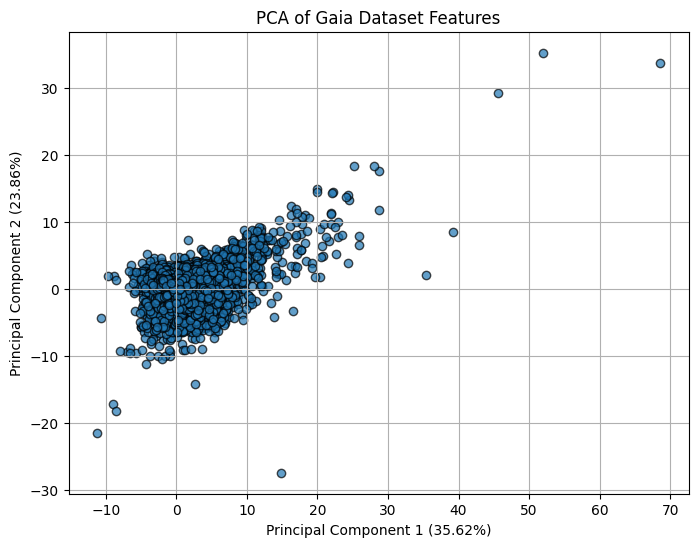

In [30]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

features = ['parallax', 'pmra', 'pmdec', 'phot_g_mean_mag']
df_features = df[features].dropna() 

scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_features)

pca = PCA(n_components=2) 
principal_components = pca.fit_transform(scaled_features)

pca_df = pd.DataFrame(
    data=principal_components, 
    columns=['Principal Component 1', 'Principal Component 2']
)

explained_variance = pca.explained_variance_ratio_
print(f"Explained Variance Ratio: {explained_variance}")


plt.figure(figsize=(8, 6))
plt.scatter(pca_df['Principal Component 1'], pca_df['Principal Component 2'], alpha=0.7, edgecolor='k')
plt.title("PCA of Gaia Dataset Features")
plt.xlabel(f"Principal Component 1 ({explained_variance[0]*100:.2f}%)")
plt.ylabel(f"Principal Component 2 ({explained_variance[1]*100:.2f}%)")
plt.grid()
plt.show()
